## Task II: Classical Graph Neural Network (GNN) 
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/records/3164691) with its corresponding description. 
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
- Discuss the resulting performance of the 2 chosen architectures. 


We will write and train Graph Neural Networks with [Pytorch-Geometric Library](https://pytorch-geometric.readthedocs.io/en/latest/index.html). 

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
import torch_geometric.data as pyg_data
import torch_geometric.loader as pyg_loader
import torch_geometric.transforms as T

import networkx as nx
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os


### Loading and pre-processing data

 PFN-ID: PFN, adding in the full particle ID information. For the case study in Sec. 4,
 particles are indicated as being one of , +, 
, K+, K , KL, n, n, p, p, e , e+,
 , 
+
 , which are represented to the model as a single oat value starting at 0 and
 increasing by 0.1 for each distinct type, respectively.

 https://arxiv.org/pdf/1810.05165.pdf

In [3]:
class QG_Jets(pyg_data.InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, force_reload=True):
        super().__init__(root, transform, pre_transform)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = glob.glob(self.root + '/raw/*.npz') 
        return [file.split('/')[-1] for file in files]

    @property
    def processed_file_names(self):
        return ['dataset.pt']

    def download(self) -> None:
        print('Download not implemented')
        pass

    def process(self):
        
        data_list = []
        print(self.raw_paths)
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            data = np.load(raw_path)

            # Access the arrays stored in the NPZ file
            pcs = data['X']
            ys = data['y']  
            
            # PDGid to float dictionary
            PID2FLOAT_MAP = {22: 0,
                 211: .1, -211: .2,
                 321: .3, -321: .4,
                 130: .5,
                 2112: .6, -2112: .7,
                 2212: .8, -2212: .9,
                 11: 1.0, -11: 1.1,
                 13: 1.2, -13: 1.3,
                 0: 1.5,  # Representing undefined PID
                 }
            
            pids = np.unique(pcs[:, :, 3]).flatten()
            for index, pc in enumerate(pcs):
                # Remove zero-padding
                pc = pc[~np.all(pc == 0, axis=1)]
                
                pt_total = np.sum(pc[:, 0])  # Total scalar sum of p_T
                
                # Center y and phi
                weighted_y = np.sum(pc[:, 0] * pc[:, 1]) / pt_total
                weighted_phi = np.sum(pc[:, 0] * pc[:, 2]) / pt_total
                pc[:, 1] = pc[:, 1] - weighted_y
                pc[:, 2] = pc[:, 2] - weighted_phi
                
                # Normalize p_T
                pc[:, 0] = pc[:, 0] / pt_total
            
                for pid in pids:
                    np.place(pc[:, 3], pc[:, 3] == pid, PID2FLOAT_MAP[pid])
            
                data = pyg_data.Data(pos = torch.tensor(pc, 
                                               dtype=torch.float), y=int(ys[index]))
                data_list.append(data)

        self.save(data_list, self.processed_paths[0])

        return data_list

#### Pytorch Lightning

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 256

class ModelPL(pl.LightningModule):
    def __init__(self, model, learning_rate=0.01):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        
        from torchmetrics import AUROC, Accuracy 
        self.train_auc = AUROC(task='binary')
        self.val_auc = AUROC(task='binary')
        self.test_auc = AUROC(task='binary')
        
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def forward(self, pos, edge_index, batch):
        # Forward pass through the model
        return self.model(pos, edge_index, batch)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                        mode='min', factor=0.25, patience=1),
            'monitor': 'val_loss', 
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, data, batch_idx):
        lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        logits = self(data.pos, data.edge_index, data.batch)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.train_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("train_auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        self.train_acc(logits.argmax(dim=-1), data.y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        return loss

    def validation_step(self, data, batch_idx):
        logits = self(data.pos, data.edge_index, data.batch)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("val_auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_acc(logits.argmax(dim=-1), data.y)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

    def test_step(self, data, batch_idx):
        logits = self(data.pos, data.edge_index, data.batch)
        
        self.test_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("test_auc", self.test_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.test_acc(logits.argmax(dim=-1), data.y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)


### GNN Models
#### PointNet++

In [17]:
class PointNetLayer(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with 'max' aggregation.
        super().__init__(aggr='max')

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden
        # node dimensionality plus point dimensionality (=4).
        self.mlp = nn.Sequential(
            nn.Linear(in_channels + 4, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        # h_j: The features of neighbors as shape [num_edges, in_channels]
        # pos_j: The position of neighbors as shape [num_edges, 3]
        # pos_i: The central node position as shape [num_edges, 3]

        edge_feat = torch.cat([h_j, pos_j - pos_i], dim=-1)
        return self.mlp(edge_feat)
    
class PointNet(torch.nn.Module):
    def __init__(self, input_features=4, hidden_dim=16, output_dim=2, dropout_rate=0.5):
        super().__init__()

        self.conv1 = PointNetLayer(input_features, hidden_dim)
        self.conv2 = PointNetLayer(hidden_dim, hidden_dim)
        # self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        # self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, pos, edge_index, batch):

        # Perform n-layers of message passing:
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        # h = self.dropout(h)
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()
        # h = self.dropout(h)
        # Global Pooling:
        h = pyg_nn.global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # Hidden Layer:
        # h = self.hidden_layer(h)
        
        # Classifier:
        return self.classifier(h)

In [8]:
class EdgeConvNet(torch.nn.Module):
    def __init__(self, input_features=4, hidden_dim=16, output_dim=2, dropout_rate=0.5):
        super(EdgeConvNet, self).__init__()
        
        # Define MLP for EdgeConv
        mlp1 = nn.Sequential(nn.Linear(2 * input_features, hidden_dim), 
                          nn.ReLU(), 
                          nn.Linear(hidden_dim, hidden_dim))
        
        mlp2 = nn.Sequential(nn.Linear(2 * hidden_dim, hidden_dim), 
                          nn.ReLU(), 
                          nn.Linear(hidden_dim, hidden_dim))
        
        # EdgeConv layers
        self.conv1 = pyg_nn.EdgeConv(mlp1)
        # self.conv2 = pyg_nn.EdgeConv(mlp2)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):
        # First EdgeConv layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = self.dropout(x)
        
        # # Second EdgeConv layer
        # x = self.conv2(x, edge_index)
        # x = F.relu(x)
        
        # Global Pooling
        x = pyg_nn.global_max_pool(x, batch)  # Aggregate features to graph level
        
        # Classifier
        x = self.classifier(x)
        
        return x

#### Graph Attention Network

In [6]:
class GATNet(nn.Module):
    def __init__(self, input_features=4, hidden_dim=16, output_dim=2, dropout_rate=0.5):
        super(GATNet, self).__init__()

        # First GATConv layer
        self.conv1 = pyg_nn.GATConv(input_features, hidden_dim)
        
        # Second GATConv layer
        # Assuming the same hidden_dim is used for in_channels and out_channels for simplicity
        self.conv2 = pyg_nn.GATConv(hidden_dim, hidden_dim)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index, batch):
        # First GATConv layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Dropout after ReLU
        x = self.dropout(x)

        # Second GATConv layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)  # Assuming ReLU is also desired here

        # Global Pooling (to aggregate node features for graph classification)
        x = pyg_nn.global_max_pool(x, batch)  # [num_examples, hidden_channels]

        # Classifier
        x = self.classifier(x)

        return x

### Training

#### Loading Dataset

Processing...


['data/QG_Jets/raw/QG_jets.npz']
data/QG_Jets/raw/QG_jets.npz


Done!


100000 Data(y=[1], pos=[18, 4]) tensor([[ 5.3666e-04,  3.8694e-01, -8.9608e-03,  0.0000e+00],
        [ 3.1963e-04, -2.2557e-01, -2.0012e-01,  0.0000e+00],
        [ 2.2936e-03, -3.2403e-02, -2.4649e-01,  2.0000e-01],
        [ 8.2497e-03,  2.0372e-01,  1.5876e-02,  4.0000e-01],
        [ 3.3865e-03, -1.8214e-01,  4.6523e-02,  2.0000e-01]])
Data(y=[1], pos=[27, 4], edge_index=[2, 270])


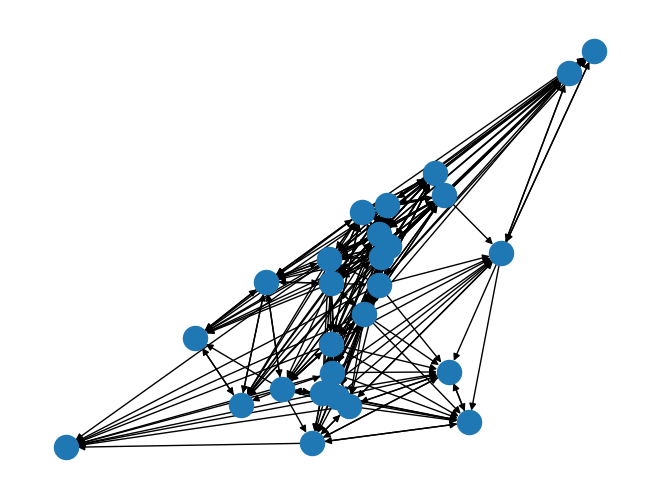

In [5]:
dataset = QG_Jets('./data/QG_Jets')
print(len(dataset), dataset[0], dataset[0].pos[:5])


#### KNNGraph Transform

Data(y=[1], pos=[27, 4], edge_index=[2, 162])


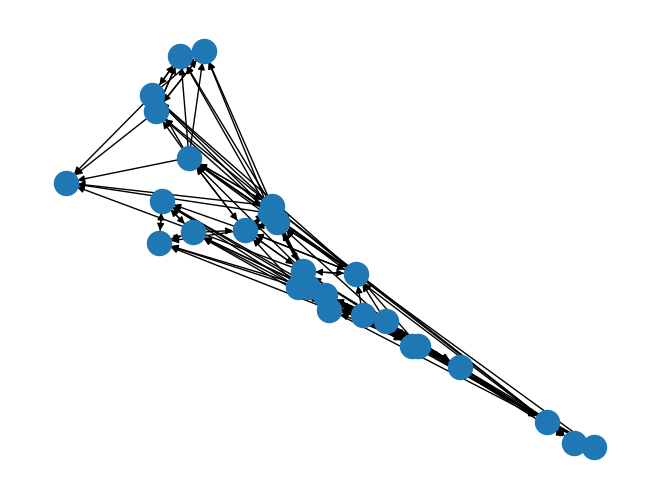

In [19]:
dataset.transform = T.Compose([T.KNNGraph(k=6)])
print(dataset[10])
nx.draw(pyg.utils.to_networkx(dataset[10]))

In [20]:
total_size = len(dataset)

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

# Split the dataset into train, val, test
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

next(iter(train_loader))

DataBatch(y=[256], pos=[11332, 4], edge_index=[2, 67980], batch=[11332], ptr=[257])

In [21]:
pointnet = PointNet() 

pointnet_pl = ModelPL(model=pointnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='pointnets')

summary_callback = pl.callbacks.ModelSummary(max_depth=10)
callbacks = [summary_callback]

trainer_pointnet = pl.Trainer(max_epochs=30, 
                              accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_pointnet.fit(pointnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_pointnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | model                   | PointNet         | 1.1 K 
1  | model.conv1             | PointNetLayer    | 416   
2  | model.conv1.aggr_module | MaxAggregation   | 0     
3  | model.conv1.mlp         | Sequential       | 416   
4  | model.conv1.mlp.0       | Linear           | 144   
5  | model.conv1.mlp.1       | ReLU             | 0     
6  | model.conv1.mlp.2       | Linear           | 272   
7  | model.conv2             | PointNetLayer    | 608   
8  | model.conv2.aggr_module | MaxAggregation   | 0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 235/235 [00:08<00:00, 26.39it/s, v_num=69, val_loss=0.462, val_auc=0.863, val_acc=0.787, learning_rate=0.0025, train_loss=0.455]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 235/235 [00:08<00:00, 26.32it/s, v_num=69, val_loss=0.462, val_auc=0.863, val_acc=0.787, learning_rate=0.0025, train_loss=0.455]


Restoring states from the checkpoint path at logs/pointnets/version_69/checkpoints/epoch=29-step=7050.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/pointnets/version_69/checkpoints/epoch=29-step=7050.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 42.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7835999727249146
        test_auc            0.8599974513053894
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [10]:
dynGCNN = EdgeConvNet() 

dynGCNN_pl = ModelPL(model=dynGCNN, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='gatnets')

summary_callback = pl.callbacks.ModelSummary(max_depth=10)
callbacks = [summary_callback]

trainer_dynGCNN = pl.Trainer(max_epochs=10, 
                              accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_dynGCNN.fit(dynGCNN_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_dynGCNN.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | model                   | EdgeConvNet      | 450   
1  | model.conv1             | EdgeConv         | 416   
2  | model.conv1.aggr_module | MaxAggregation   | 0     
3  | model.conv1.nn          | Sequential       | 416   
4  | model.conv1.nn.0        | Linear           | 144   
5  | model.conv1.nn.1        | ReLU             | 0     
6  | model.conv1.nn.2        | Linear           | 272   
7  | model.classifier        | Linear           | 34    
8  | model.dropout           | Dropout          | 0     
9  | criterion               | CrossEntropyLoss | 0     
10 | train_auc               | BinaryAUROC      | 0     
11 | val_auc                 | BinaryAUROC      | 0     
1

Epoch 9: 100%|██████████| 235/235 [00:10<00:00, 23.42it/s, v_num=13, val_loss=0.476, val_auc=0.854, val_acc=0.781, learning_rate=0.010, train_loss=0.475]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 235/235 [00:10<00:00, 23.37it/s, v_num=13, val_loss=0.476, val_auc=0.854, val_acc=0.781, learning_rate=0.010, train_loss=0.475]


Restoring states from the checkpoint path at logs/gatnets/version_13/checkpoints/epoch=9-step=2350.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/gatnets/version_13/checkpoints/epoch=9-step=2350.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 32.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7718999981880188
        test_auc            0.8471547365188599
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [13]:
gatnet = GATNet() 

gatnet_pl = ModelPL(model=gatnet, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='gatnets')

summary_callback = pl.callbacks.ModelSummary(max_depth=10)
callbacks = [summary_callback]

trainer_gatnet = pl.Trainer(max_epochs=10, 
                              accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                              callbacks=callbacks,
                              logger=logger,)

train_result = trainer_gatnet.fit(gatnet_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_gatnet.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | model                   | GATNet           | 450   
1  | model.conv1             | GATConv          | 112   
2  | model.conv1.aggr_module | SumAggregation   | 0     
3  | model.conv1.lin         | Linear           | 64    
4  | model.conv2             | GATConv          | 304   
5  | model.conv2.aggr_module | SumAggregation   | 0     
6  | model.conv2.lin         | Linear           | 256   
7  | model.classifier        | Linear           | 34    
8  | model.dropout           | Dropout          | 0 

Epoch 0:   0%|          | 1/235 [00:00<02:35,  1.50it/s, v_num=8]          

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9: 100%|██████████| 235/235 [00:11<00:00, 21.15it/s, v_num=8, val_loss=1.030, val_auc=0.610, val_accuracy=0.519, learning_rate=0.000625, train_loss=0.597]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 235/235 [00:11<00:00, 21.11it/s, v_num=8, val_loss=1.030, val_auc=0.610, val_accuracy=0.519, learning_rate=0.000625, train_loss=0.597]


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/gatnets/version_8/checkpoints/epoch=9-step=2350.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/gatnets/version_8/checkpoints/epoch=9-step=2350.ckpt


Testing DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 34.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.509592592716217
        test_auc             0.61078280210495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Results

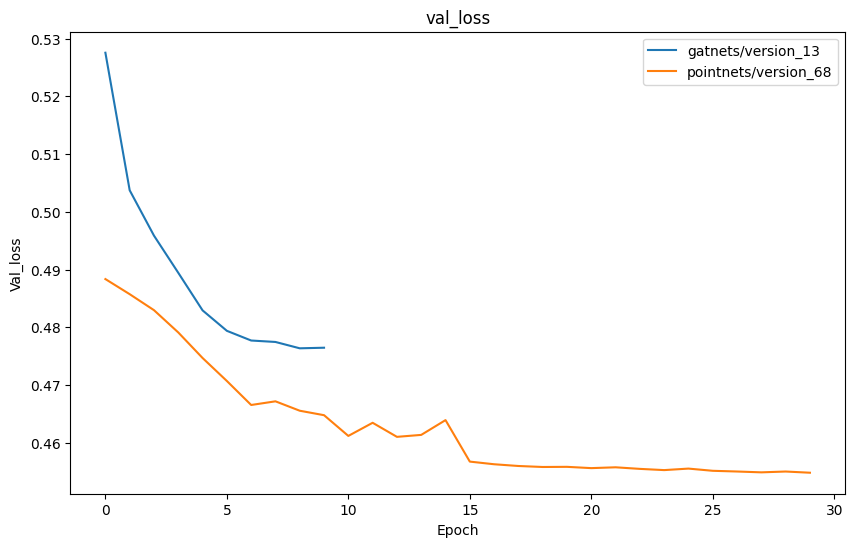

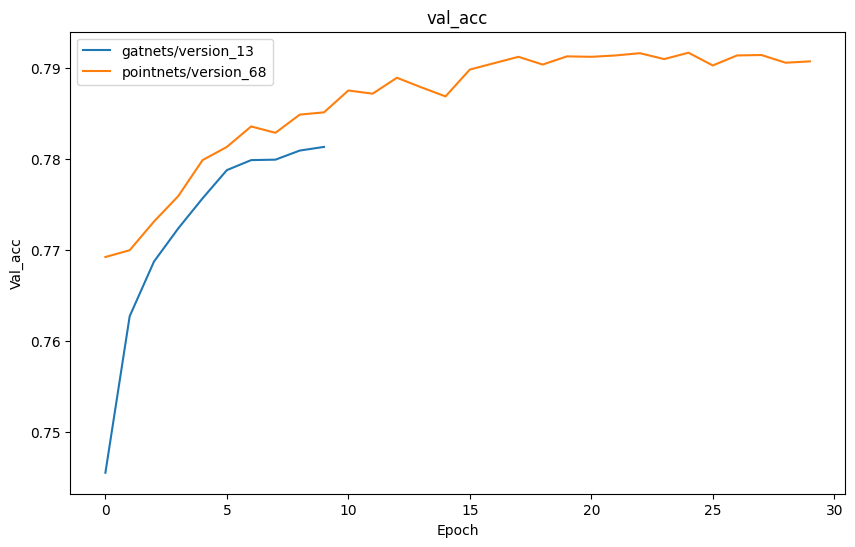

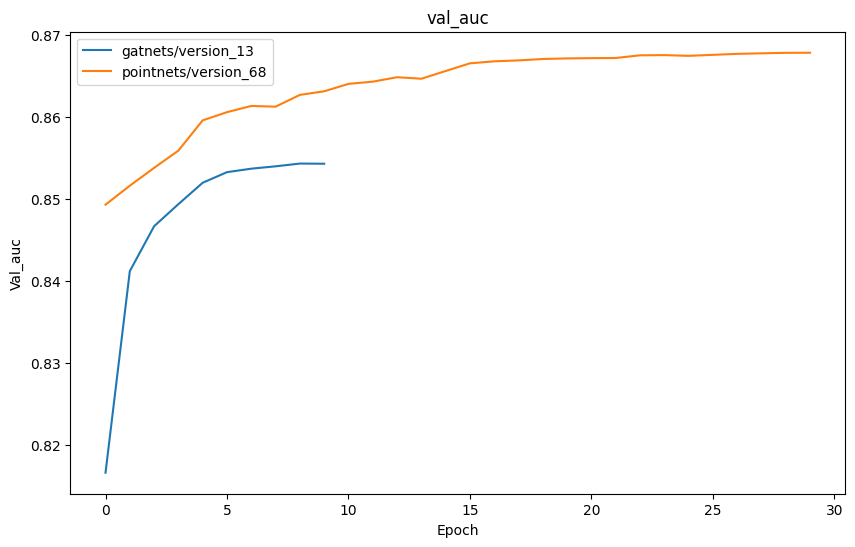

In [43]:
# Define the directory where your logs are stored
log_dir = 'logs'
models = ['gatnets/version_13', 'pointnets/version_68']  # Add your model names here

# Initialize an empty DataFrame to hold all the data
model_metrics = {}

# Iterate over models and read their metrics
for model in models:
    file_path = os.path.join(log_dir, model, 'metrics.csv')
    if os.path.exists(file_path):
        model_metrics[model] = pd.read_csv(file_path).groupby('epoch').mean()
    else:
        print(f"File not found for model: {model}")
        
metrics_to_plot = ['val_loss', 'val_acc', 'val_auc']

# Create a plot for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    
    for model, df in model_metrics.items():
        # Check if the metric column exists in the dataframe
        if metric in df.columns:
            plt.plot(df.index, df[metric], label=model)
    
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

### Conclusion